In [1]:
%matplotlib inline

In [2]:
import yaml
import logging
import contextlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import List, Optional
from multiprocessing.pool import Pool
from multiprocessing import Queue, Manager

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

In [4]:
def mk_job_id(router_type, seed):
    return '{}:{}'.format(router_type, seed)

def un_job_id(job_id):
    [router_type, s_seed] = job_id.split(':')
    return router_type, int(s_seed)

def add_avg(df: pd.DataFrame):
    df['avg'] = df['sum'] / df['count']
    return df

def plot_avgs(figsize=(15,5), xlim=None, ylim=None, **dfs):
    fig = plt.figure(figsize=figsize)
    handles = []
    for (label, df) in dfs.items():
        if 'min_avg' in df.columns:
            # this is combined data, draw errorbar
            minerr = df['avg'] - df['min_avg']
            maxerr = df['max_avg'] - df['avg']
            line = plt.errorbar(df['time'], df['avg'],
                                 yerr=[minerr, maxerr], label=label)
        else:
            line, = plt.plot(df['time'], df['avg'], label=label)
        handles.append(line)
        
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
        
    plt.legend(handles=handles)
    plt.show()
    
def combine_launch_data(launch_data):
    data_unwrapped = {}
    for (job_id, data) in launch_data.items():
        router_type, seed = un_job_id(job_id)
        if router_type not in data_unwrapped:
            data_unwrapped[router_type] = []
        data_unwrapped[router_type].append(data)
    
    result_data = {}
    for (router_type, runs) in data_unwrapped.items():
        df = runs[0].copy()
        df['min_avg'] = df['avg']
        df['max_avg'] = df['avg']
        for run in runs[1:]:
            df['sum'] += run['sum']
            df['count'] += run['count']
            df['min_avg'] = df['min_avg'].combine(run['avg'], min)
            df['max_avg'] = df['max_avg'].combine(run['avg'], max)
        df = add_avg(df)
        result_data[router_type] = df
    return result_data

In [5]:
class DummyTqdmFile(object):
    """Dummy file-like that will write to tqdm"""
    file = None
    def __init__(self, file):
        self.file = file

    def write(self, x):
        # Avoid print() second call (useless \n)
        if len(x.rstrip()) > 0:
            tqdm.write(x, file=self.file)

    def flush(self):
        return getattr(self.file, "flush", lambda: None)()

@contextlib.contextmanager
def std_out_err_redirect_tqdm():
    orig_out_err = sys.stdout, sys.stderr
    try:
        sys.stdout, sys.stderr = map(DummyTqdmFile, orig_out_err)
        yield orig_out_err[0]
    # Relay exceptions
    except Exception as exc:
        raise exc
    # Always restore sys.stdout/err if necessary
    finally:
        sys.stdout, sys.stderr = orig_out_err

In [6]:
class DummyProgressbarQueue:
    def __init__(self, bar):
        self.bar = bar
        
    def put(self, val):
        _, _, delta = val
        if delta is not None:
            self.bar.update(delta)

In [7]:
def run_network_scenario_file(file: str, router_type: str, random_seed: int = None,
                              progress_step: Optional[int] = None, progress_queue: Optional[Queue] = None,
                              series_period: int = 500,
                              series_funcs: List[str] = ['count', 'sum', 'min', 'max']):
    """
    Helper wrapper around `run_network_scenario` which should run in a separate thread.
    """
    
    # Importing here because of problemes with Tensorflow in multiple threads
    from dqnroute import event_series, run_network_scenario, DQNROUTE_LOGGER, TF_MODELS_DIR

    logger = logging.getLogger(DQNROUTE_LOGGER)
    TF_MODELS_DIR = '../tf_models'
    #logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
    
    with open(file) as f:
        run_params = yaml.safe_load(f)
    
    series = event_series(series_period, series_funcs)
    series = run_network_scenario(run_params, router_type, series, random_seed=random_seed,
                                  progress_step=progress_step, progress_queue=progress_queue)
    return add_avg(series.getSeries())

def run_threaded(func, router_types: List[str], random_seeds: List[int], *args, **kwargs):
    """
    Runs several scenario runners in multiple threads and displays progress bars for them
    """

    pool = Pool()
    m = Manager()
    queue = m.Queue()
    jobs = {}
    bars = {}
    for router_type in router_types:
        for seed in random_seeds:
            job_id = mk_job_id(router_type, seed)
            job_args = dict(kwargs, router_type=router_type, random_seed=seed,
                            progress_queue=queue)
            jobs[job_id] = pool.apply_async(func, args=args, kwds=job_args,
                                            error_callback=print)
            bars[job_id] = tqdm(desc=job_id)

    # TODO: fix progressbars somehow
    while len(bars) > 0:
        (rt, s, val) = queue.get()
        job_id = mk_job_id(rt, s)
        if val is None:
            bars.pop(job_id).close()
        else:
            bars[job_id].update(val)
        
    return {job_id: job.get() for (job_id, job) in jobs.items()}

In [ ]:
launch6_data_mult = run_threaded(run_network_scenario_file, random_seeds=[42, 43, 44],
                                 file='../launches/launch6.yaml', router_types=['simple_q', 'link_state', 'dqn'],
                                 progress_step=500)

In [11]:
launch6_data_comb = combine_launch_data(launch6_data_mult)

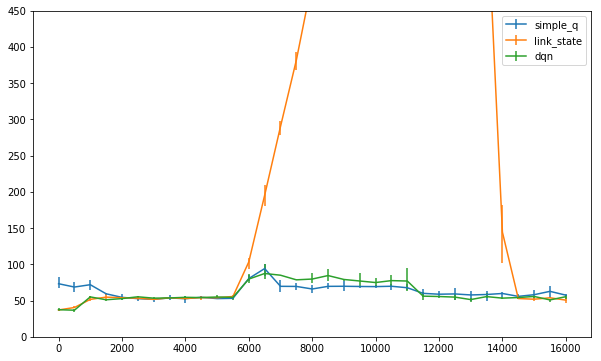

In [12]:
plot_avgs(figsize=(10,6), ylim=(0,450), **launch6_data_comb)

In [14]:
launch8_data = run_threaded(run_network_scenario_file, file='../launches/launch8.yaml',
                            router_types=['simple_q', 'link_state', 'dqn'], progress_step=500,
                            random_seeds=[42, 43, 44])

launch8_data_comb = combine_launch_data(launch8_data)

simple_q:42: 0it [00:00, ?it/s]
simple_q:43: 0it [00:00, ?it/s]

simple_q:44: 0it [00:00, ?it/s]


link_state:42: 0it [00:00, ?it/s]



link_state:43: 0it [00:00, ?it/s]




link_state:44: 0it [00:00, ?it/s]





dqn:42: 0it [00:00, ?it/s]






dqn:43: 0it [00:00, ?it/s]







dqn:44: 0it [00:00, ?it/s]Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
simple_q:42: 1500it [00:26, 39.64it/s]

simple_q:42: 2000it [00:26, 56.03it/s][A

simple_q:44: 1000it [00:26, 27.29it/s]


link_state:42: 500it [00:26, 18.84it/s]

simple_q:42: 2500it [00:26, 78.98it/s]


link_state:42: 1000it [00:26, 26.81it/s]

simple_q:42: 3000it [00:26, 110.09it/s][A


link_state:42: 1500it [00:27, 38.09it/s]

simple_q:42: 3500it [00:27, 153.64it/s][A
simple_q:43: 500it [00:27, 18.33it/s]


link_state:42: 2000it [00:27, 53.98it/s]

simple_q:42: 4000it [00:27, 212.82it/s]
simple_q:43: 1000it [00:27, 26.09it/s]


link_state:42: 2500it [00:27, 76.24it/s]

simple_q:4

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 7500it [00:53, 777.72it/s]
link_state:43: 8000it [00:53, 909.03it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:43: 8500it [00:53, 1057.92it/s][A
link_state:43: 9000it [00:54, 1152.85it/s][A
link_state:44: 8000it [00:54, 883.86it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 9500it [00:54, 1263.33it/s]
link_state:43: 10000it [00:54, 1288.24it/s]A
link_state:44: 9000it [00:55, 1110.25it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 10500it [00:55, 1374.71it/s]
link_state:43: 11000it [00:55, 1474.13it/s][A

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:43: 12000it [00:56, 1563.23it/s]
link_state:44: 10500it [00:56, 1257.76it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 12500it [00:56, 1503.34it/s]
link_state:43: 13500it [00:57, 1591.52it/s]
link_state:43: 14000it [00:57, 1675.11it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:44: 12000it [00:57, 1141.92it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 14500it [00:57, 1408.19it/s]
link_state:43: 15000it [00:58, 1395.52it/s]
link_state:44: 13000it [00:58, 1226.32it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 15500it [00:58, 1417.35it/s]
link_state:44: 13500it [00:58, 1195.30it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 16000it [00:58, 1409.94it/s]
link_state:43: 16500it [00:59, 1447.50it/s]
link_state:44: 14500it [00:59, 1358.39it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 17000it [00:59, 1436.46it/s]
link_state:44: 15000it [00:59, 1298.23it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 17500it [00:59, 1452.58it/s]
link_state:43: 18000it [01:00, 1505.51it/s]
link_state:44: 16000it [01:00, 1464.12it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 18500it [01:00, 1499.13it/s]
link_state:44: 16500it [01:00, 1426.02it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 19000it [01:01, 1447.92it/s]
link_state:43: 19500it [01:01, 1480.45it/s]
link_state:44: 17500it [01:01, 1568.17it/s]
link_state:43: 20000it [01:01, 1284.97it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:43: 20500it [01:02, 1341.78it/s]
link_state:43: 21000it [01:02, 1326.93it/s]
link_state:43: 21500it [01:02, 1370.68it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 22000it [01:03, 1524.21it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:43: 22500it [01:03, 1571.71it/s]
link_state:43: 23000it [01:03, 1725.07it/s]
link_state:43: 24000it [01:04, 1848.69it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



link_state:44: 21500it [01:04, 1428.19it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


link_state:43: 24500it [01:04, 1892.95it/s]
link_state:43: 25000it [01:04, 1836.67it/s]
link_state:43: 25500it [01:04, 1882.56it/s]
link_state:43: 26000it [01:05, 1854.32it/s]
link_state:43: 26500it [01:05, 1836.40it/s]
link_state:44: 24000it [01:05, 1815.18it/s]
link_state:43: 27000it [01:05, 1731.31it/s]
link_state:43: 27500it [01:06, 1780.95it/s]
link_state:43: 28000it [01:06, 1692.81it/s]
link_state:43: 28500it [01:06, 1560.77it/s]
link_state:43: 29000it [01:07, 1688.04it/s]
link_state:43: 29500it [01:07, 1721.66it/s]
link_state:44: 27500it [01:07, 1959.49it/s]
link_state:43: 30000it [01:07, 1580.46it/s]
link_state:43: 30500it [01:07, 1653.72it/s]
link_state:43: 31000it [01:08, 1672.14it/s]
link_state:43: 31500it [01:08, 1694.26it/s]
link_state:43: 32000it [01:08, 1630.74it/s]
link_state:43: 32500it [01:09, 1648.16it/s]
link_state:43: 33000it [01:09, 1676.42it/s]
link_state:43: 33500it [01:09, 1542.47it/s]
link_state:44: 32000it [01:09, 1745.76it/s]

link_state:43: 34000it [01:10, 

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


dqn:42: 1000it [01:13,  9.99it/s]
dqn:43: 1000it [01:14,  9.91it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


dqn:42: 1500it [01:17, 13.80it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64



dqn:43: 1500it [01:18, 13.67it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


dqn:42: 2000it [01:20, 18.91it/s]
dqn:43: 2000it [01:22, 18.64it/s]

dqn:42: 2500it [01:24, 25.60it/s][A

dqn:44: 1000it [01:25,  8.45it/s]
dqn:42: 3000it [01:28, 33.69it/s]

dqn:44: 1500it [01:29, 11.76it/s]
dqn:42: 3500it [01:31, 43.50it/s]

dqn:44: 2000it [01:33, 16.16it/s]
dqn:42: 4000it [01:35, 54.37it/s]
dqn:43: 4000it [01:37, 54.12it/s]

dqn:42: 4500it [01:39, 66.05it/s]

dqn:44: 3000it [01:40, 29.28it/s]
dqn:42: 5000it [01:43, 77.98it/s]

dqn:44: 3500it [01:44, 38.22it/s]
dqn:42: 5500it [01:46, 89.69it/s]

dqn:44: 4000it [01:48, 48.85it/s]
dqn:42: 6000it [01:50, 101.17it/s][A

dqn:44: 4500it [01:52, 59.44it/s]
dqn:42: 6500it [01:55, 97.17it/s] [A

dqn:44: 5000it [01:56, 70.26it/s]
dqn:43: 6500it [01:59, 90.61it/s]

dqn:42: 7000it [02:03, 85.96it/s]

dqn:44: 6000it [02:04, 89.89it/s]
dqn:42: 7500it [02:10, 81.13it/s]

dqn:44: 6500it [02:11, 82.78it/s]
dqn:42: 8000it [02:16, 79.74it/s]
dqn:43: 8000it [02:18, 81.14it/s]

dqn:42: 8500it [02:23, 77.11it/s]

dqn:44: 7500it [02:25, 79

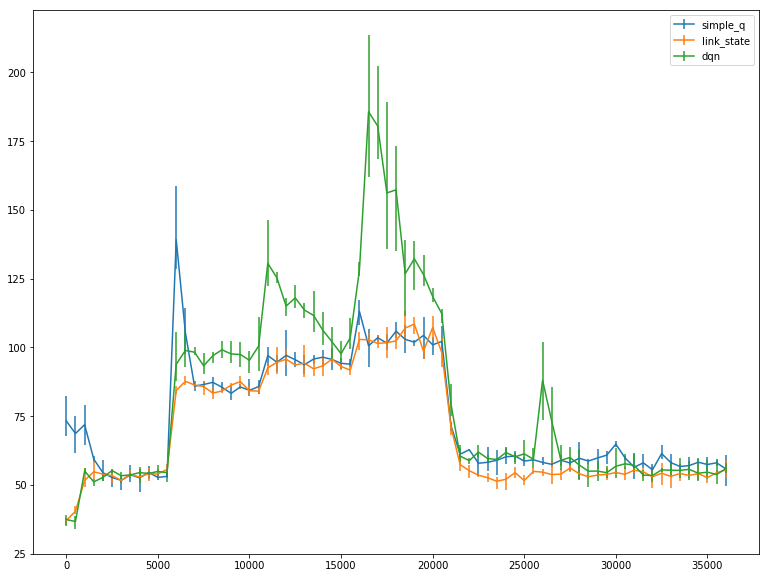

In [16]:
plot_avgs(figsize=(13,10), **launch8_data_comb)

In [7]:
launch6_data_rand_ = run_threaded(run_network_scenario_file, random_seeds=[12, 13],
                                  file='../launches/launch6.yaml', router_types=['simple_q', 'link_state'],
                                  progress_step=500)
launch6_data_rand = combine_launch_data(launch6_data_rand_)

simple_q:12: 0it [00:00, ?it/s]
simple_q:13: 0it [00:00, ?it/s]

link_state:12: 0it [00:00, ?it/s]


link_state:13: 0it [00:00, ?it/s]

name 'POMPDAgent' is not defined
name 'POMPDAgent' is not defined
name 'POMPDAgent' is not defined
name 'POMPDAgent' is not defined


Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/nix/store/yk7hci7pg3n2kyjh8il317wvd5nam3aw-python3-3.6.7/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/nix/store/yk7hci7pg3n2kyjh8il317wvd5nam3aw-python3-3.6.7/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/nix/store/yk7hci7pg3n2kyjh8il317wvd5nam3aw-python3-3.6.7/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/nix/store/yk7hci7pg3n2kyjh8il317wvd5nam3aw-python3-3.6.7/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/nix/store/yk7hci7pg3n2kyjh8il317wvd5nam3aw-python3-3.6.7/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._k

KeyboardInterrupt: 

In [9]:
dummy_data = run_network_scenario_file(random_seed=12, file='../launches/launch6.yaml',
                                       router_type='simple_q')

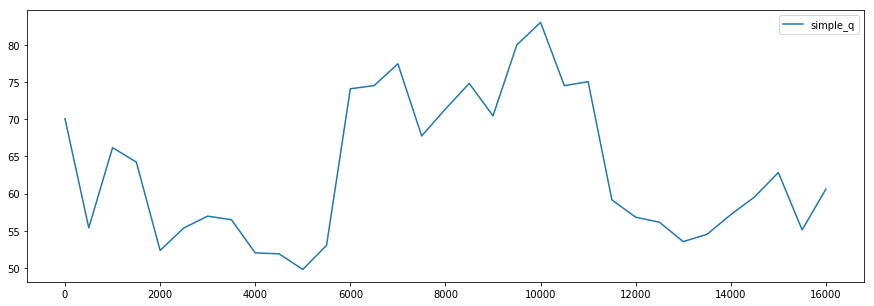

In [10]:
plot_avgs(simple_q=dummy_data)

0it [00:00, ?it/s]

INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64
INFO:tensorflow:Restoring parameters from ../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64


16300it [02:17, 247.28it/s]


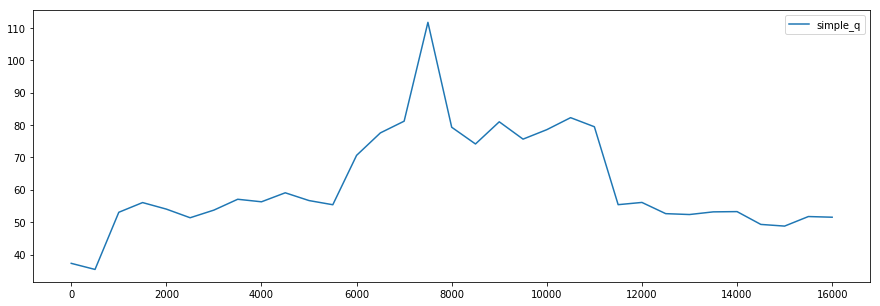

In [11]:
with tqdm() as bar:
    queue = DummyProgressbarQueue(bar)
    dummy_data2 = run_network_scenario_file(random_seed=12, file='../launches/launch6.yaml',
                                            router_type='dqn', progress_step=100, progress_queue=queue)
plot_avgs(simple_q=dummy_data2)